#**Prediction of English Language Proficiency Assessments for California (ELPAC) Scores Using Machine Learning Approach**

###**TEAM MEMBERS: TEAM 3:  EMMA OO, LUKE AWINO, OSCAR GIL**

###**Applied Data Science Master’s Program, Shiley Marcos School of Engineering / University of San Diego**

**DATE:  11/12/2022**


In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3

from sklearn.utils import resample
import warnings 
warnings.filterwarnings(action= 'ignore')

###**EXPLORATORY DATA ANALYSIS (EDA)**

In [2]:
# Import file
df = pd.read_csv('https://raw.githubusercontent.com/OscarG-DataSci/ADS-599B/main/Data%20Folder/elpac.csv')

In [3]:
df.head()

,AcademicYear,Stu_deID,School_deID,GradeLevel,DOB,TestAge,StudentGender,StudentEthnicity,Special_Education,Homeless,SocioEconomically,TestDayName,TestDate,OverallScore,OverallLevel,ExpectedAttendanceDays,DaysAttended,AttendedPct,EnrolledPct,GradeEnrolledPct,GradeAttendedPct,TeacherGender,TeacherTotalYearsOfService,TeacherEthnicity
0,2017-2018,0,3,1,2011-07-04,6.828340,F,Hispanic,N,Y,Y,Wednesday,2018-05-02,1503,4,180.0,175.0,0.972222,1.0,1.999999,1.972222,F,4,Hispanic
1,2017-2018,1,5,4,2008-07-28,9.631957,M,Hispanic,N,N,Y,Friday,2018-03-16,1535,3,180.0,168.0,0.933333,1.0,4.999999,4.933333,F,2,Multiple
2,2017-2018,3,3,4,2008-05-06,9.905748,M,Hispanic,Y,N,N,Monday,2018-04-02,1480,2,180.0,175.0,0.972222,1.0,4.999999,4.972222,F,18,White
3,2017-2018,4,3,0,2012-04-13,6.108271,M,Hispanic,N,N,Y,Wednesday,2018-05-23,1461,4,180.0,125.0,0.694444,1.0,0.999999,0.694444,F,1,White
4,2017-2018,5,7,0,2011-09-25,6.664066,M,Hispanic,N,N,Y,Friday,2018-05-25,1357,1,180.0,165.0,0.916667,1.0,0.999999,0.916667,F,17,Hispanic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11628 entries, 0 to 11627
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AcademicYear                11628 non-null  object 
 1   Stu_deID                    11628 non-null  int64  
 2   School_deID                 11628 non-null  int64  
 3   GradeLevel                  11628 non-null  int64  
 4   DOB                         11628 non-null  object 
 5   TestAge                     9469 non-null   float64
 6   StudentGender               11628 non-null  object 
 7   StudentEthnicity            11628 non-null  object 
 8   Special_Education           11628 non-null  object 
 9   Homeless                    11628 non-null  object 
 10  SocioEconomically           11628 non-null  object 
 11  TestDayName                 9469 non-null   object 
 12  TestDate                    9469 non-null   object 
 13  OverallScore                116

In [5]:
# Convert date fields to datetime
df['DOB'] =  pd.to_datetime(df.DOB)
df['TestDate'] =  pd.to_datetime(df.TestDate)

In [6]:
df.head(3)

,AcademicYear,Stu_deID,School_deID,GradeLevel,DOB,TestAge,StudentGender,StudentEthnicity,Special_Education,Homeless,SocioEconomically,TestDayName,TestDate,OverallScore,OverallLevel,ExpectedAttendanceDays,DaysAttended,AttendedPct,EnrolledPct,GradeEnrolledPct,GradeAttendedPct,TeacherGender,TeacherTotalYearsOfService,TeacherEthnicity
0,2017-2018,0,3,1,2011-07-04,6.828340,F,Hispanic,N,Y,Y,Wednesday,2018-05-02,1503,4,180.0,175.0,0.972222,1.0,1.999999,1.972222,F,4,Hispanic
1,2017-2018,1,5,4,2008-07-28,9.631957,M,Hispanic,N,N,Y,Friday,2018-03-16,1535,3,180.0,168.0,0.933333,1.0,4.999999,4.933333,F,2,Multiple
2,2017-2018,3,3,4,2008-05-06,9.905748,M,Hispanic,Y,N,N,Monday,2018-04-02,1480,2,180.0,175.0,0.972222,1.0,4.999999,4.972222,F,18,White


###**MISSING VALUES, DUPLICATES, AND SCORES WITH ZERO VALUES**

###**MISSING VALUES**

In [7]:
# Missing data value counts by AcademicYear
# Most missing data is from when the pandemic quarantine went into effect, March, 2020
# The 2020-2021 school year also has many students who did not test due to distance learning, making it difficult to test all students
df[(df.TestDate.isna() == True)]['AcademicYear'].value_counts().sort_index(ascending=False)

2020-2021     858
2019-2020    1255
2018-2019      46
Name: AcademicYear, dtype: int64

In [8]:
# Initial view of shape and missing data
print("Shape: ",df.shape,"\n")

# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (11628, 24) 



,Missing
TestAge,2159
TestDayName,2159
TestDate,2159
AttendedPct,3
GradeAttendedPct,3


In [9]:
# Re-load data omitting missing data
df = df[(df.TestDate.isna() == False)]

print("Shape: ",df.shape,"\n")

# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (9469, 24) 



,Missing
AttendedPct,2
GradeAttendedPct,2


In [10]:
# Repeat...to verify no more data is missing
df = df[(df.AttendedPct.isna() == False)]

print("Shape: ",df.shape,"\n")

# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (9467, 24) 



,Missing


####**SCORES WITH 0 VALUES**

In [11]:
# omit records where scores are zero
df = df.query("OverallScore != 0")
df.shape

(9460, 24)

####**DUPLICATES**

In [12]:
#check for duplicated rows in the dataset
duplicated_rows = df[df.duplicated()] 
print("number of duplicate rows: ", duplicated_rows.shape)

number of duplicate rows:  (0, 24)


###**STANDARDIZATION OF OVERALLSCORE VALUES**

####**Since the OverallScore values range differently between grade levels, standardization was performed to obtain the normal distribution.**

In [13]:
# View ranges of OverallScore by grade level, to determine if they are all uniform.
df.groupby('GradeLevel').agg({'OverallScore': ['min', 'max']})

OverallScore      
                    min   max
GradeLevel                   
0                  1150  1700
1                  1150  1627
2                  1150  1700
3                  1150  1672
4                  1150  1731
5                  1150  1731
6                  1150  1729

In [14]:
# to Standardize OverallScore values, as the ranges are different between grade levels
grdLevel_describe = []

for g in range(len(pd.DataFrame(df.GradeLevel.unique()))):

    grdLevel_describe.append({'GradeLevel': g,
                             'OverallScoreMin': pd.DataFrame(df.query("GradeLevel == @g").OverallScore.describe().to_list()).iloc[3].values[0],
                             'OverallScoreMax': pd.DataFrame(df.query("GradeLevel == @g").OverallScore.describe().to_list()).iloc[7].values[0]})   

pd.DataFrame(grdLevel_describe) 

,GradeLevel,OverallScoreMin,OverallScoreMax
0,0,1150.0,1700.0
1,1,1150.0,1627.0
2,2,1150.0,1700.0
3,3,1150.0,1672.0
4,4,1150.0,1731.0
5,5,1150.0,1731.0
6,6,1150.0,1729.0


In [15]:
# Bring in min and max columns to df dataframe
df = df.merge(pd.DataFrame(grdLevel_describe) , left_on=('GradeLevel'), right_on=('GradeLevel'))

In [16]:
# Standardize Overall Score
df['OverallScoreStd'] = (df.OverallScore - df.OverallScoreMin) / (df.OverallScoreMax - df.OverallScoreMin)

In [17]:
# Confirm min and max OverallScore standardized values range from 0 to 1 for each grade level
df.groupby('GradeLevel').agg({'OverallScoreStd': ['min', 'max']})

OverallScoreStd     
                       min  max
GradeLevel                     
0                      0.0  1.0
1                      0.0  1.0
2                      0.0  1.0
3                      0.0  1.0
4                      0.0  1.0
5                      0.0  1.0
6                      0.0  1.0

###**QUERIES**
####**QUERY OF NUMBER OF STUDENTS WITH MINIMUM OVERALLSCAORE PER ACADEMIC YEAR**

In [18]:
# There are several students who should a result along the zero score line, on scatter plots.
# These are the student counts whose OverallScore equals the minimum score, by AcademicYear
df.query("OverallScore == @df.OverallScoreMin").AcademicYear.value_counts().sort_index()

2017-2018    12
2018-2019    10
2019-2020     3
2020-2021    15
2021-2022     1
Name: AcademicYear, dtype: int64

In [19]:
# Drop columns used for the OverallScoreStd, which are no longer necessary
df = df.drop(['OverallScoreMin', 'OverallScoreMax'], axis=1)
df.shape

(9460, 25)

####**TOTAL ELPAC ASSESSMENTS:  TOTAL TIMES THE STUDENT HAS TESTED**

In [20]:
# Total ELPAC Assessments; total times the student student has tested
total_assessments = df['Stu_deID'].reset_index().groupby( ['Stu_deID'],as_index=False ).count()
total_assessments.columns = ['Stu_deID', 'TotalAssessments']

# Add column TotalAssessments to data frame
df = df.merge(total_assessments, left_on=('Stu_deID'), right_on=('Stu_deID'), how='inner')

####**OVERALLLEVEL GROWTH FROM ONE TEST INSTANCE TO THE NEXT**


In [21]:
# Capture TestInstance of student assessments, numbering each instance in ascending order, 
# #re-seeding for each student, as opposed to a running number; similar to SQL's RowNum() function
df['TestInstance'] =  df.sort_values(['Stu_deID', 'TestAge'], ascending=True).groupby(['Stu_deID']).cumcount() + 1

In [22]:
# Capture unique TestInstance combinations available in dataframe
TestInstances = []

# the [:-1] ensures that the max number (5) cuts off at 5 for comparison purposes, 
# or else it would be trying to compare with 6, which is non-existent in the dataframe
for i in range(len(df.TestInstance.unique()[:-1])):
  i += 1
  n = i+1

  TestInstances.append({'TestInstanceA': i,
                        'TestInstanceB': n})
  
pd.DataFrame(TestInstances)

,TestInstanceA,TestInstanceB
0,1,2
1,2,3
2,3,4
3,4,5


In [23]:
# Merge test instances into main data frame
df = df.merge(pd.DataFrame(TestInstances), left_on='TestInstance', right_on='TestInstanceA', how='left')


# Create dataframes for instance A and B, respectively
df2a = df[['Stu_deID', 'OverallLevel', 'TestInstanceA']]
df2b = df[['Stu_deID', 'OverallLevel', 'TestInstanceB']]


# Left join dataframes A and B, to align OverallLevels where TestInstances A and B match, yet keep rows where they do not
df2 = df2a.merge(df2b, left_on=('Stu_deID', 'TestInstanceA'), right_on=('Stu_deID', 'TestInstanceB'), how='left')


# Subtract the most recent OverallLevel from previous, to get a Growth result
df2['Growth'] = df2.OverallLevel_x - df2.OverallLevel_y


# Subset the data in preparation to join it back to the main dataframe
df2 = df2[['Stu_deID', 'TestInstanceA', 'Growth']]
df2.columns = ['Stu_deID', 'TestInstance', 'Growth']


# Bring the Growth variable into the main dataframe
df = df.merge(df2, left_index=True, right_index=True, how='left')


# Convert Growth from float to int, filling in with 0 wherever there is data missing
df['Growth'] = df.Growth.fillna(0).astype(int)

# Sort values and reindex
df = df.sort_values(['Stu_deID_x', 'TestInstanceA'], ascending=True, ignore_index=True)

# Subset
df = df.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 31]]
df.columns = ['AcademicYear', 'Stu_deID', 'School_deID', 'GradeLevel', 'DOB', 'TestAge', 'StudentGender', 'StudentEthnicity'
, 'Special_Education', 'Homeless', 'SocioEconomically', 'TestDayName', 'TestDate', 'OverallScore', 'OverallLevel'
, 'ExpectedAttendanceDays', 'DaysAttended', 'AttendedPct', 'EnrolledPct', 'GradeEnrolledPct', 'GradeAttendedPct'
, 'TeacherGender', 'TeacherTotalYearsOfService', 'TeacherEthnicity', 'OverallScoreStd', 'TotalAssessments', 'TestInstance', 'Growth']


In [25]:
# Spot check
df.query("Stu_deID == 14")[['Stu_deID', 'GradeLevel', 'TestAge', 'OverallLevel', 'TotalAssessments', 'TestInstance', 'Growth']]

,Stu_deID,GradeLevel,TestAge,OverallLevel,TotalAssessments,TestInstance,Growth
34,14,2,7.704470,2,3,1,0
35,14,4,10.001574,3,3,2,1
36,14,5,10.822946,3,3,3,0


###**DATA VISUALIZATION**

####**RELATIONSHIPS BETWEEN OVERALLEVEL VS GROWTH**
####**OVERALLELVEL VS TESTINSTANCE**
####**TESTINSTANCE VS GROWTH**

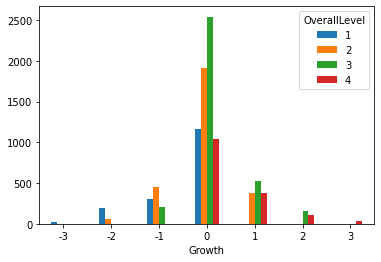

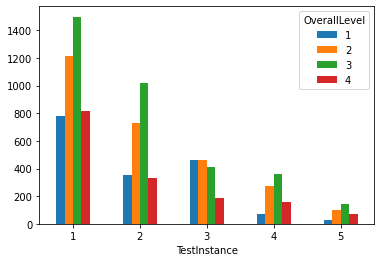

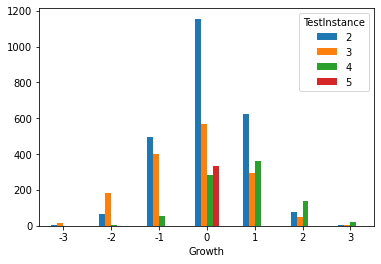

In [24]:
pd.crosstab(df.Growth, df.OverallLevel).plot.bar(rot=0)

pd.crosstab(df.TestInstance, df.OverallLevel).plot.bar(rot=0)

pd.crosstab(df.query("TestInstance > 1").Growth, df.query("TestInstance > 1").TestInstance).plot.bar(rot=0)

####**CORRELATION AMONG FEATURES**

In [26]:
# Identify features that are object dtype, to create dummy variables for
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9460 entries, 0 to 9459
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   AcademicYear       9460 non-null   object
 1   StudentGender      9460 non-null   object
 2   StudentEthnicity   9460 non-null   object
 3   Special_Education  9460 non-null   object
 4   Homeless           9460 non-null   object
 5   SocioEconomically  9460 non-null   object
 6   TestDayName        9460 non-null   object
 7   TeacherGender      9460 non-null   object
 8   TeacherEthnicity   9460 non-null   object
dtypes: object(9)
memory usage: 665.3+ KB


In [27]:
# Create dummy values from 'object' data types to get correlation values
df2 = pd.get_dummies(df, columns=['AcademicYear', 'StudentGender', 'StudentEthnicity', 'Special_Education', 'Homeless', 'SocioEconomically', 'TestDayName',
                                  'TeacherGender','TeacherEthnicity'])

In [28]:
# Correlation for dummy variables for Overall Score
cor = pd.DataFrame(df2.corrwith(df2['OverallScore']))
cor.columns = ['Correlation']
cor.head(20).sort_values('Correlation', ascending=False).style.bar(align="mid", color=["red", "lightgreen"])

,Correlation
OverallScore,1.000000
OverallScoreStd,0.943589
OverallLevel,0.739880
TestAge,0.436677
GradeAttendedPct,0.427772
GradeEnrolledPct,0.425248
GradeLevel,0.424732
Growth,0.325504
TestInstance,0.280874
AttendedPct,0.099292


In [29]:
# Correlation for dummy variables for Overall Level
cor = pd.DataFrame(df2.corrwith(df2['OverallLevel']))
cor.columns = ['Correlation']
cor.head(20).sort_values('Correlation', ascending=False).style.bar(align="mid", color=["red", "lightgreen"])

,Correlation
OverallLevel,1.000000
OverallScoreStd,0.752161
OverallScore,0.739880
Growth,0.395979
AcademicYear_2017-2018,0.147472
DaysAttended,0.084942
AttendedPct,0.080637
ExpectedAttendanceDays,0.046723
EnrolledPct,0.046723
School_deID,0.042032


####**CORRELATION MATRIX**

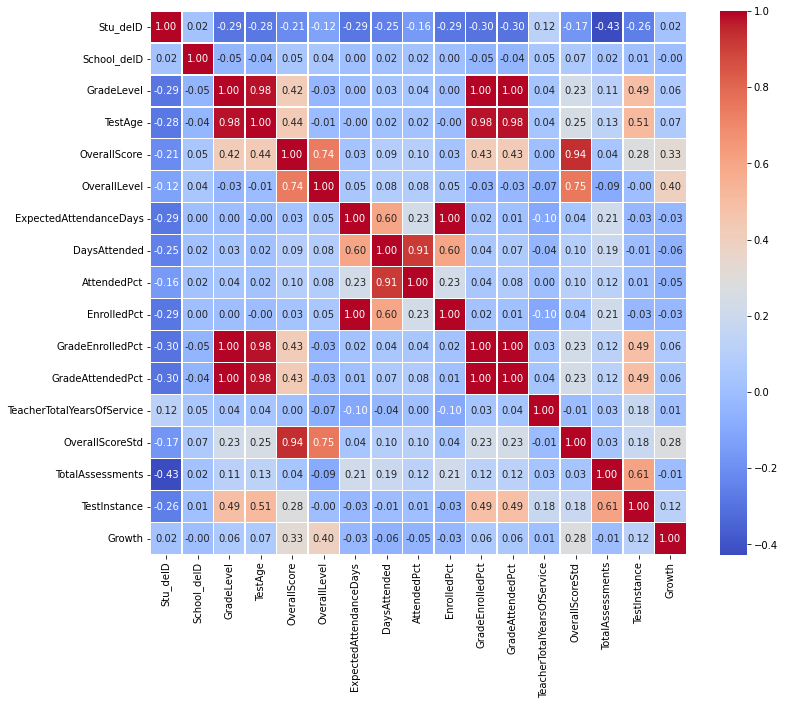

In [30]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (12,10))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)

There's a strong correlation between GradeEnrolledPact and TestAge, GradeAttendedPct and GradeLevel, OverallScoreStd and OverallScore, AttendedPct and DaysAttended. 

In [31]:
#Split numerical and categorical dataframes for visualization purpose

#for num_df, only extract the useful columns and drop the columns such as 'Stu_deID'

num_df = df[['School_deID','GradeLevel','TestAge','OverallLevel','ExpectedAttendanceDays','DaysAttended',
           'AttendedPct', 'EnrolledPct' ,'GradeEnrolledPct', 'GradeAttendedPct','TeacherTotalYearsOfService',
           'OverallScoreStd','TotalAssessments']]

#for cat_df, keep only the suitable features for visualization 
cat_df = df[['AcademicYear','StudentGender','StudentEthnicity','Special_Education','Homeless','SocioEconomically','TestDayName',
           'TeacherGender','TeacherEthnicity']]

####**DISTRIBUTION BETWEEN CATEGORICAL VARIABLES**

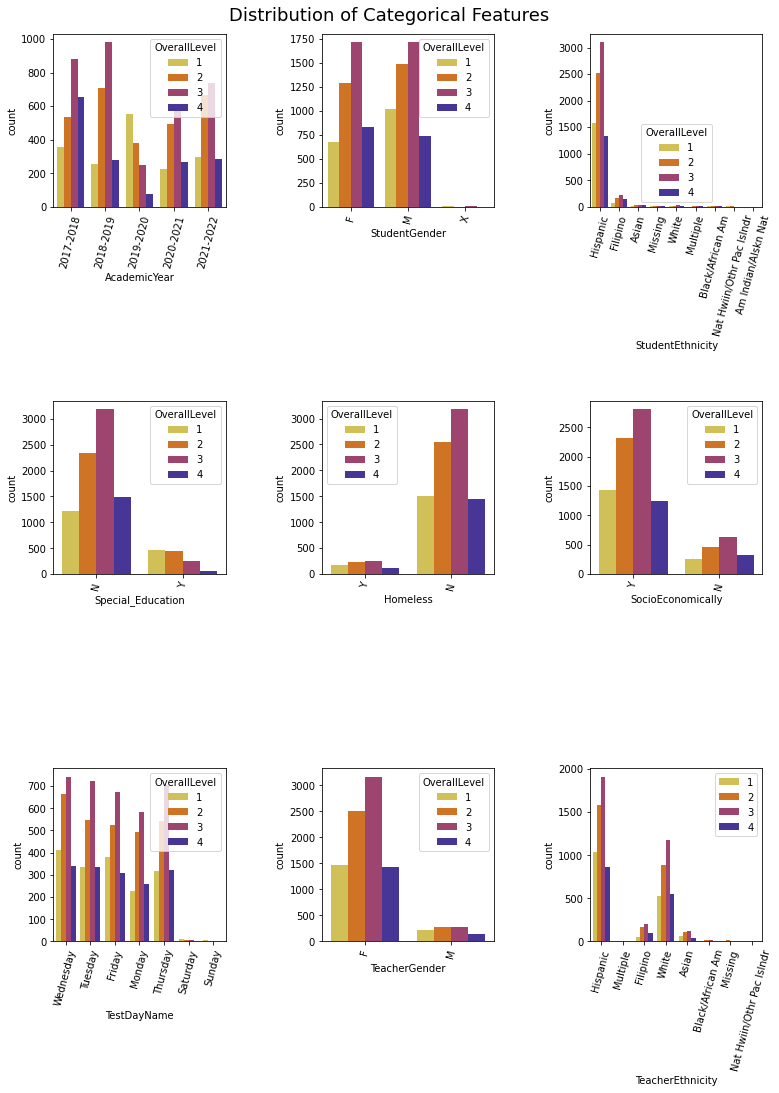

In [32]:
fig , ax = plt.subplots(3,3, figsize = (12,16))     # set up 2 x 2 frame count plot with figsize 10 x 10
fig.suptitle("Distribution of Categorical Features", fontsize=18)

for i , subplots in zip (cat_df, ax.flatten()):
  g = sns.countplot(cat_df[i],hue = df['OverallLevel'],ax = subplots, palette = 'CMRmap_r')
  g.set_xticklabels(labels=cat_df[i].unique(), rotation= 75)


fig.tight_layout(pad= 5.0)
plt.legend(loc = 'upper right')
plt.show()

####**DISTRIBUTION PLOTS OF NUMERICAL VARIABLES**


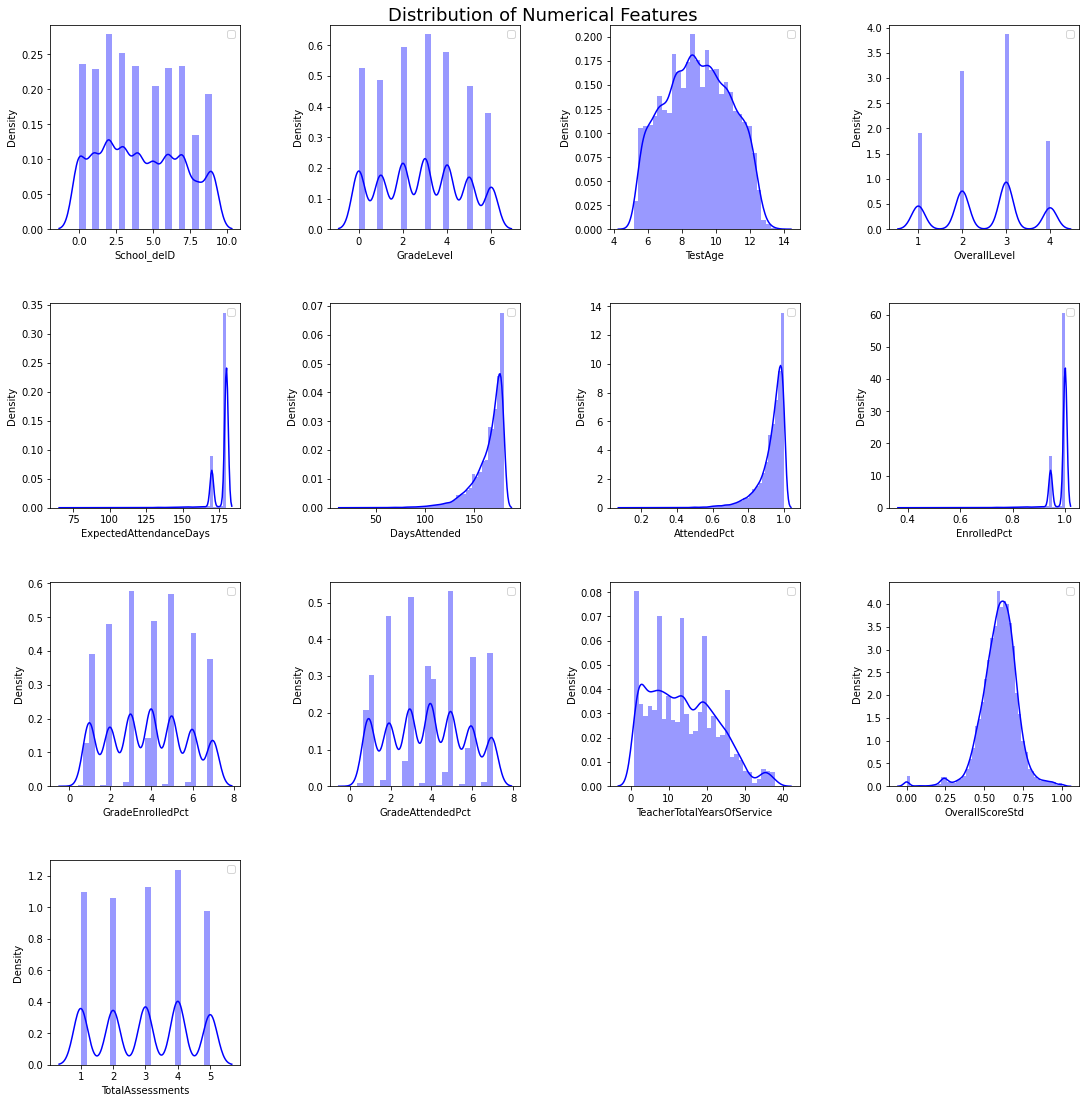

In [51]:
fig , ax = plt.subplots(3,3, figsize = (16,16))     
fig.suptitle("Distribution of Numerical Features", fontsize=18)

for i, column in enumerate(num_df, 1):
    plt.subplot(4, 4, i)
    sns.distplot(x=num_df[column], color = 'blue') 
    plt.legend() 
    plt.xlabel(column)
    fig.tight_layout(pad=4.0)

####**DISTRIBUTION OF OVERALLEVEL BY GRADE AND TOTAL ASSESSMENTS**

TotalAssessments    1    2    3    4    5
OverallLevel                             
1                 349  333  324  359  322
2                 489  496  563  655  578
3                 568  641  731  842  649
4                 481  354  323  272  131


<Figure size 432x288 with 0 Axes>

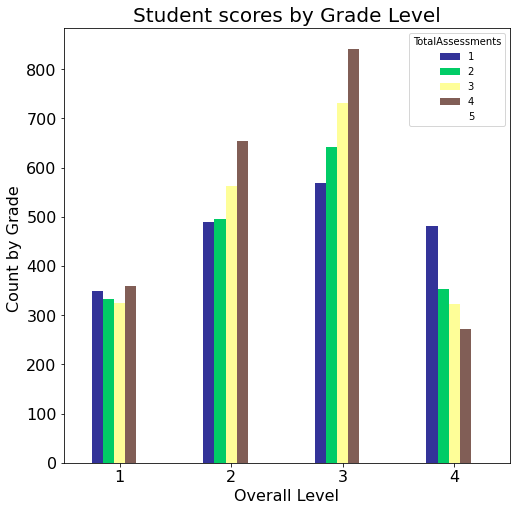

In [34]:
#Crosstab for Student scores by Grade Level
test_assessments = test =  pd.crosstab(index=df.OverallLevel, columns=df.TotalAssessments)
print(test_assessments)
#plot the figure
fig1 = plt.figure()
temp = test_assessments.plot.bar(colormap="terrain", fontsize=16, figsize=(8,8), rot=0) #https://matplotlib.org/stable/tutorials/colors/colormaps.html#sequential
temp = plt.title('Student scores by Grade Level', fontsize=20)
temp = plt.ylabel('Count by Grade ', fontsize=16)
temp = plt.xlabel('Overall Level', fontsize=16)

####**DISTRIBUTION OF OVERALLEVEL BY GRADE AND GRADE LEVEL**

GradeLevel      0    1    2    3    4    5    6
OverallLevel                                   
1             202  252  160  384  272  167  250
2             480  394  377  537  379  321  293
3             476  369  600  542  622  500  322
4             199  238  395  178  219  220  112


<Figure size 432x288 with 0 Axes>

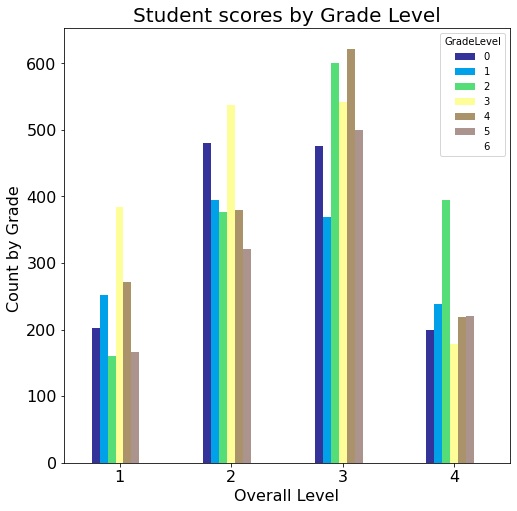

In [35]:
#Crosstab for Student scores by Grade Level
test =  pd.crosstab(index=df.OverallLevel, columns=df.GradeLevel)
print(test)
#plot the figure
fig = plt.figure()
temp = test.plot.bar(colormap="terrain", fontsize=16, figsize=(8,8), rot=0) #https://matplotlib.org/stable/tutorials/colors/colormaps.html#sequential
temp = plt.title('Student scores by Grade Level', fontsize=20)
temp = plt.ylabel('Count by Grade ', fontsize=16)
temp = plt.xlabel('Overall Level', fontsize=16)

###**FEATURE ENGINEERING**

####**DISTRIBUTION OF TARGET CLASSES: OVERALLLEVEL**


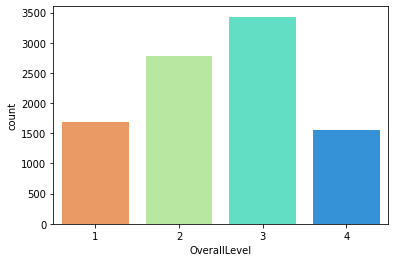

In [36]:
fig_szie=(12,8)
sns.countplot(df['OverallLevel'], data = df, palette = 'rainbow_r')

A slight class-imbalance was observed amaong the scores.

Upsampling will be performed for level 1,2, 4 as reference to level 3 count.

A new data balanced dataset named 'bal_df' will be trained with models to see the accuracy performance improvement. 


In [37]:
#split four different datasets for downsampling

lev_0 = df[df['OverallLevel'] == 0]
lev_1 = df[df['OverallLevel'] == 1]
lev_2 = df[df['OverallLevel'] == 2]
lev_3 = df[df['OverallLevel'] == 3]
lev_4 = df[df['OverallLevel'] == 4]

In [38]:
lev1_upsample = resample(lev_1,replace=True,n_samples=len(lev_3),random_state=42)
lev2_upsample = resample(lev_2,replace=True,n_samples=len(lev_3),random_state=42)
lev4_upsample = resample(lev_4,replace=True,n_samples=len(lev_3),random_state=42)

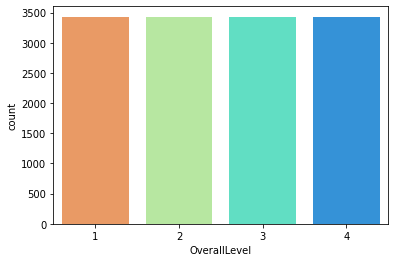

In [39]:
#create a new dataframe with balanced datasets

frames = (lev1_upsample, lev2_upsample, lev_3, lev4_upsample)
bal_df = pd.concat(frames)

fig_szie=(12,8)
sns.countplot(bal_df['OverallLevel'], data = bal_df, palette = 'rainbow_r')

###**FEATURE ENGINEERING TO DO LISTS**

According to the data visualization plots, here are the steps for feature engineering.

GradeEnrolledPct, AttendedPct will be dropped from the data frame to avoid multicollinearity.

TestAge is the student's age on the date of the ELPAC test. For example, for record #1, the student was born on 7/4/2011 and student is 11 year old. TestAge of the student is 6.828340. Since GradeLevel and TestAge are highly correlated and age column was also populated, it's safe to drop the TestAge to avoid multicollinearity.

Other insignificant columns such as 'AcademicYear', 'Stu_deID', 'DOB', 'TestDate' will also be dropped.

Unique value X in 'StudentGender' will be replaced with the mode of each feature column for each train and test data set to avoid data leakage.

Label-encoding will be performed for categorical variables.

Dataset will be split into Train and test dataset.

In [40]:
new_df = df.drop(columns = ['AcademicYear','Stu_deID','DOB','TestAge','GradeEnrolledPct',
                             'AttendedPct','TestDate'])

In [41]:
##replace X value from StudentGender with Mode value for StudentGender column
print(new_df['StudentGender'].mode())
new_df['StudentGender'] = new_df['StudentGender'].replace(to_replace = 'M', value = 'X') #replace X value with mode


0    M
dtype: object


###**LABEL-ENCODING FOR CATEGORICAL VARIABLES**

In [42]:
cat_columns = ['StudentGender','StudentEthnicity','Special_Education','Homeless','SocioEconomically',
               'TestDayName','TeacherGender','TeacherEthnicity']

In [43]:
from sklearn.preprocessing import LabelEncoder

#Train dataset
label_encoders = {}
for column in cat_columns:
  label_encoders[column] = LabelEncoder()
  new_df[column] = label_encoders[column].fit_transform(new_df[column])

####**DATA DICTIONARY FOR LABEL-ENCODER VALUES** 

In [44]:
# TeacherEthnicity - description and label encoder value
TeacherEthnicity = pd.concat([df.TeacherEthnicity, new_df.TeacherEthnicity], axis=1)
TeacherEthnicity.columns = ['TeacherEthnicity', 'le']
TeacherEthnicity.value_counts().sort_index()

TeacherEthnicity           le
Asian                      0      332
Black/African Am           1       46
Filipino                   2      516
Hispanic                   3     5387
Missing                    4       18
Multiple                   5        8
Nat Hwiin/Othr Pac Islndr  6       16
White                      7     3137
dtype: int64

In [45]:
# TestDayName - description and label encoder value
TestDayName = pd.concat([df.TestDayName, new_df.TestDayName], axis=1)
TestDayName.columns = ['TestDayName', 'le']
TestDayName.value_counts().sort_index()

TestDayName  le
Friday       0     1884
Monday       1     1564
Saturday     2       23
Sunday       3       12
Thursday     4     1883
Tuesday      5     1936
Wednesday    6     2158
dtype: int64

In [46]:
# StudentEthnicity - description and label encoder value
StudentEthnicity = pd.concat([df.StudentEthnicity, new_df.StudentEthnicity], axis=1)
StudentEthnicity.columns = ['StudentEthnicity', 'le']
StudentEthnicity.value_counts().sort_index()

StudentEthnicity           le
Am Indian/Alskn Nat        0        1
Asian                      1      130
Black/African Am           2       25
Filipino                   3      595
Hispanic                   4     8544
Missing                    5       32
Multiple                   6       40
Nat Hwiin/Othr Pac Islndr  7       13
White                      8       80
dtype: int64

In [47]:
# TeacherGender - description and label encoder value
TeacherGender = pd.concat([df.TeacherGender, new_df.TeacherGender], axis=1)
TeacherGender.columns = ['TeacherGender', 'le']
TeacherGender.value_counts().sort_index()

TeacherGender  le
F              0     8573
M              1      887
dtype: int64

In [48]:
# Special_Education - description and label encoder value
Special_Education = pd.concat([df.Special_Education, new_df.Special_Education], axis=1)
Special_Education.columns = ['Special_Education', 'le']
Special_Education.value_counts().sort_index()

Special_Education  le
N                  0     8234
Y                  1     1226
dtype: int64

In [49]:
# # Save a version of the clean file
# new_df.to_csv('/Users/oscargil/Desktop/ADS-599B/Data Folder/new_elpac.csv', encoding='utf-8', index=False)

###**DATA PARTITIONING**

Split dataset into 70% train and 30% test datasets.  

In [50]:
from sklearn.model_selection import train_test_split

X = new_df.loc[ : , new_df.columns != 'OverallLevel']
y = new_df[['OverallLevel']]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=700, test_size=0.30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6622, 20) (6622, 1) (2838, 20) (2838, 1)


###**Now the train and test dataset are ready for modelings.**